# Explore VCI Predictions

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
base_dir = Path(".").absolute().parents[0]
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    download_test_jena_data,
    load_test_jena_data_as_dataset
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in config file and predictions

In [3]:
ds = pickle.load((base_dir / "data/kenya.pkl").open("rb"))
ds

<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.25 -4.5 -4.75 -5.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    boku_VCI    (time, lat, lon) float64 43.72 31.13 85.88 20.18 ... nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.4688 0.4032 0.624 ... nan nan nan
    VCI         (time, lat, lon) float64 39.64 37.79 89.79 53.54 ... nan nan nan
    precip      (time, lat, lon) float64 13.66 18.42 24.78 47.38 ... nan nan nan
    E           (time, lat, lon) float64 52.86 64.59 64.59 75.49 ... nan nan nan
    Eb          (time, lat, lon) float64 2.3 2.311 2.311 2.409 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2993 0.3273 0.3273 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2837 0.309 0.309 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.121e-05 3.69e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.007123 -0.007165 ... nan nan
    sp          (time, lat, lon) float64 9.591e+04 9.604e+04 ... nan nan
    t2m         (time, lat, lon) float64 303.0 303.8 302.2 299.3 ... nan nan nan
    tp          (time, lat, lon) float64 0.0004198 0.0003483 ... nan nan

In [26]:
RUN = "kenya_static_2602_165902"

run_dir = base_dir / f"runs/{RUN}/"
cfg = Config(run_dir / "config.yml")
cfg

{'autoregressive': True,
 'batch_size': 100,
 'clip_gradient_norm': None,
 'constant_mean': None,
 'constant_std': None,
 'data_dir': PosixPath('data/kenya.pkl'),
 'device': 'cuda:0',
 'dropout': 0.4,
 'early_stopping': 10,
 'encode_doys': True,
 'experiment_name': 'kenya_static',
 'forecast_variables': ['precip', 't2m', 'SMsurf'],
 'hidden_size': 32,
 'horizon': 1,
 'input_variables': ['precip', 't2m', 'SMsurf'],
 'learning_rate': 0.001,
 'loss': 'huber',
 'model': 'lstm',
 'n_epochs': 60,
 'num_workers': 4,
 'optimizer': 'AdamW',
 'pixel_dims': ['lat', 'lon'],
 'run_dir': PosixPath('/home/tommy/spatio_temporal/runs/kenya_static_2602_165902'),
 'scheduler': 'cycle',
 'seed': 1234,
 'seq_length': 3,
 'static_inputs': 'embedding',
 'target_variable': 'boku_VCI',
 'test_end_date': Timestamp('2020-12-31 00:00:00'),
 'test_start_date': Timestamp('2016-01-31 00:00:00'),
 'time_str': 'time',
 'train_end_date': Timestamp('2015-12-31 00:00:00'),
 'train_start_date': Timestamp('2002-01-01 00:00

In [27]:
import pickle 

normalizer = pickle.load((run_dir / "normalizer.pkl").open("rb"))

In [28]:
updated_mean = normalizer.mean_.copy()
updated_mean

<xarray.Dataset>
Dimensions:   (sample: 1575)
Coordinates:
  * sample    (sample) <U11 '6.0_33.75' '6.0_34.0' ... '-5.0_42.0' '-5.0_42.25'
Data variables:
    precip    (sample) float64 76.97 83.6 84.98 105.0 91.77 ... nan nan nan nan
    t2m       (sample) float64 302.6 303.2 302.2 299.7 ... 299.6 299.6 299.6
    SMsurf    (sample) float64 0.3456 0.355 0.355 0.3659 ... nan nan nan nan
    boku_VCI  (sample) float64 49.05 52.39 48.7 55.55 55.26 ... nan nan nan nan

In [29]:
# if isinstance(mean_values, float):
#     updated_mean[cfg.target_variable] = 

# updated_mean[cfg.target_variable]

In [30]:
mean_values = 5

In [31]:
shape = tuple([shape for shape in normalizer.mean_.dims.values()])

# updated_mean[cfg.target_variable]

In [32]:
updated_mean[cfg.target_variable]

<xarray.DataArray 'boku_VCI' (sample: 1575)>
array([49.05309402, 52.39321237, 48.69566058, ...,         nan,
               nan,         nan])
Coordinates:
  * sample   (sample) <U11 '6.0_33.75' '6.0_34.0' ... '-5.0_42.0' '-5.0_42.25'

# Are the train Test Periods equivalent?
- test period is worse vegetation health

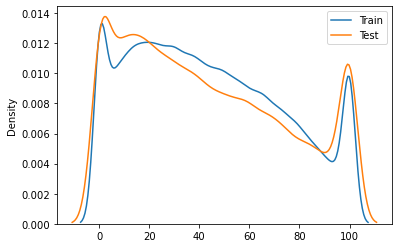

In [33]:
test = ds.sel(time=slice(cfg._cfg["test_start_date"], cfg._cfg["test_end_date"]))
train = ds.sel(time=slice(cfg._cfg["train_start_date"], cfg._cfg["train_end_date"]))

train_target = train[cfg.target_variable].values.flatten()
test_target = test[cfg.target_variable].values.flatten()

sns.kdeplot(train_target, label="Train")
sns.kdeplot(test_target, label="Test")
plt.legend()

# Explore Predictions

In [34]:
xr_path = sorted(list(run_dir.glob("*.nc")))[-1]
preds = xr.open_dataset(xr_path).drop("horizon")
preds

<xarray.Dataset>
Dimensions:  (pixel: 1405, time: 31)
Coordinates:
  * time     (time) datetime64[ns] 2016-05-31T00:00:42.290642944 ... 2018-11-...
  * pixel    (pixel) object '-0.25_34.25' '-0.25_34.5' ... '6.0_42.25'
Data variables:
    sim      (time, pixel) float64 ...
    obs      (time, pixel) float64 ...

(0.0, 100.0)

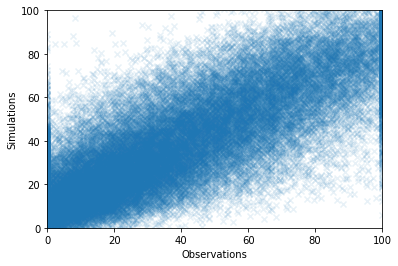

In [45]:
from spatio_temporal.training.eval_utils import _plot_scatter
f, ax = _plot_scatter(preds);
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

In [62]:
r2 = float(xr.corr(preds["obs"], preds["sim"]).values)

error = preds["obs"] - preds["sim"]
rmse = np.sqrt(((error)**2).mean(xr.ALL_DIMS))
rmse = float(rmse.values)

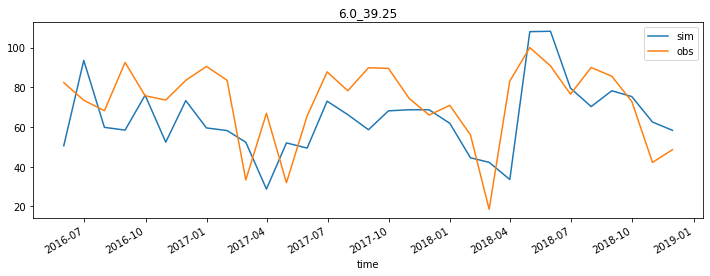

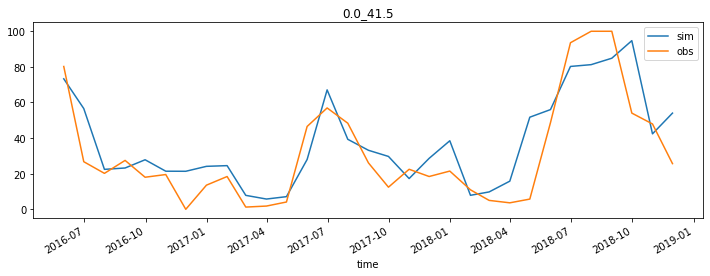

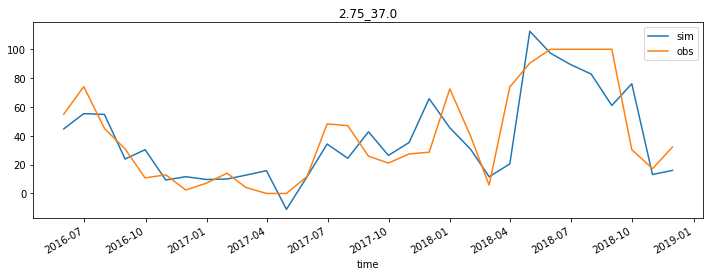

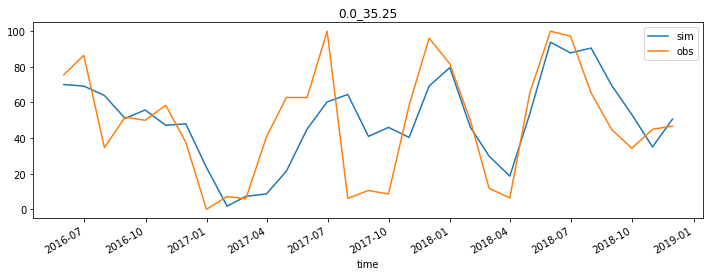

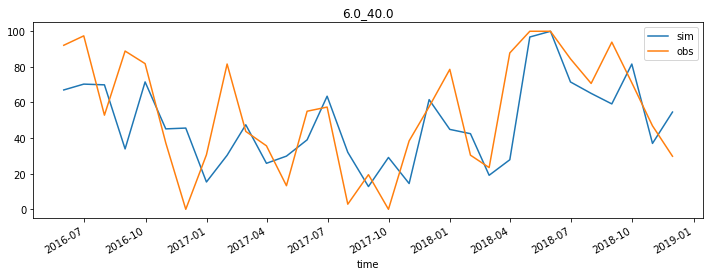

In [36]:
for i in range(5):
    f, ax = plt.subplots(figsize=(12, 4))
    pixel = np.random.choice(preds.pixel.values)
    preds.sel(pixel=pixel).to_dataframe().plot(ax=ax)
    ax.set_title(pixel)

In [40]:
cfg._cfg["run_dir"] = run_dir
cfg._cfg["device"] = "cpu"
trainer = Trainer(cfg, ds)


Loading Data: 100%|██████████| 1575/1575 [00:03<00:00, 425.48it/s]


In [42]:
dataset = trainer.train_dl.dataset
dataset.__getitem__(1)

{'meta': {'index': 1, 'target_time': tensor(1.0254e+18)},
 'x_d': tensor([[-0.0945,  0.4409, -0.9261,  0.0311, -0.4775, -0.8786],
         [-0.6108,  0.6192, -0.6555,  0.1937, -0.8827,  0.4700],
         [-0.4451,  0.3918,  0.1016, -0.4572,  0.4925,  0.8703]]),
 'y': tensor([[-1.6129]]),
 'x_s': tensor([1., 0., 0.,  ..., 0., 0., 0.]),
 'x_f': tensor([[-0.0945,  0.4409, -0.9261],
         [-0.6108,  0.6192, -0.6555],
         [-0.4451,  0.3918,  0.1016],
         [ 0.6680,  0.0427,  0.0304]])}

# ARIMA

In [15]:
from spatio_temporal.data.data_utils import _stack_xarray

# Get the timeseries 
TARGET = cfg.target_variable
TARGET = "boku_VCI"
stacked, _ = _stack_xarray(ds[TARGET], spatial_coords=cfg.pixel_dims)
stacked = stacked.dropna(how="all", dim="sample")

train_ds = stacked.sel(time=slice(cfg.train_start_date, cfg.train_end_date))
test_ds = stacked.sel(time=slice(cfg.test_start_date, cfg.test_end_date))

pixel = np.random.choice(stacked.sample)
tgt_mean = train_ds.mean(dim="sample").to_dataframe()[TARGET]
tgt = train_ds.sel(sample=pixel).to_dataframe()[TARGET]

test_tgt = test_ds.sel(sample=pixel).to_dataframe()[TARGET]

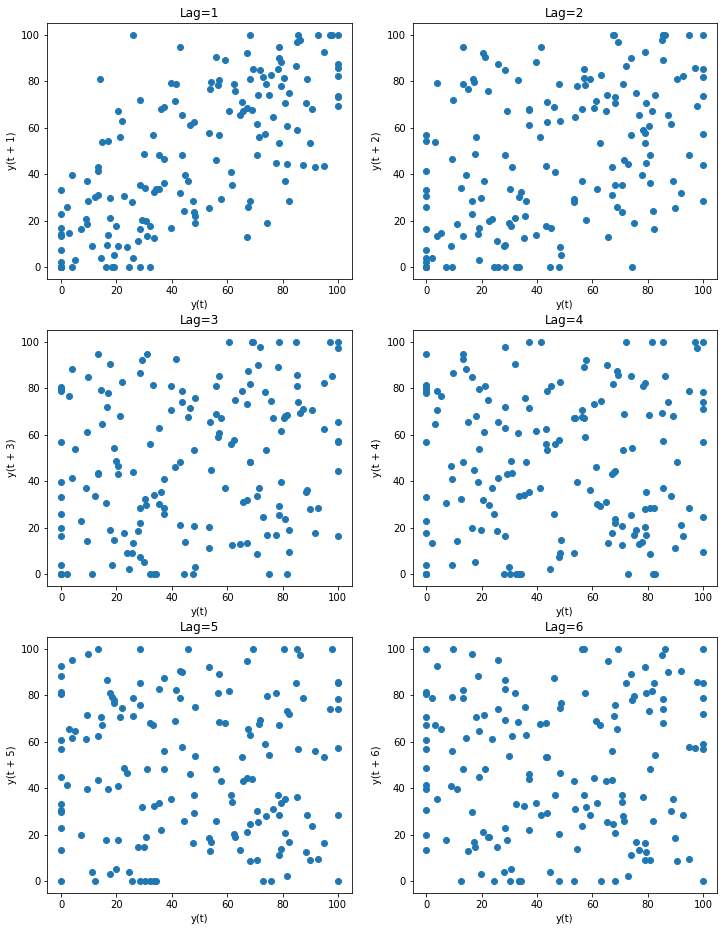

In [16]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(12, 16))
plt.title(f'{TARGET} Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(tgt, lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
    
plt.show()

In [17]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(tgt.dropna(), alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(tgt.dropna(), alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

if n_diffs > 0:
    print(f"Estimated differencing term: {n_diffs}")
else:
    print(f"Time series is judged constant")

Time series is judged constant


### remove seasonality?

In [18]:
from pmdarima import preprocessing as ppc
# print(dir(ppc))
transformer = ppc.FourierFeaturizer(m=12, k=3)

transformer.fit(tgt)
transformed_target, fourier = transformer.fit_transform(tgt)

time
2002-01-31    47.794118
2002-02-28    28.448276
2002-03-31     0.000000
2002-04-30     0.000000
2002-05-31     7.211538
Name: boku_VCI, dtype: float64

time
2002-01-31    47.794118
2002-02-28    28.448276
2002-03-31     0.000000
2002-04-30     0.000000
2002-05-31     7.211538
Name: boku_VCI, dtype: float64

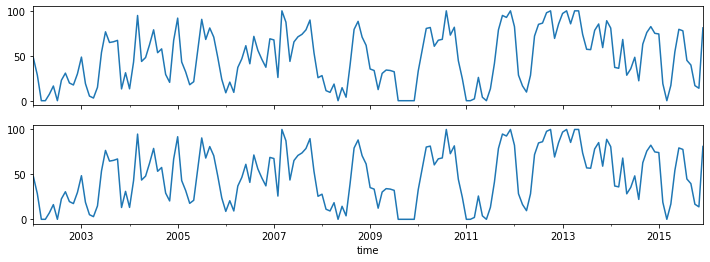

In [19]:
import warnings
warnings.filterwarnings("ignore")

display(transformed_target[:5])
display(tgt[:5])

f, axs = plt.subplots(2, 1, figsize=(12, 2*2), sharex=True, sharey=True)
tgt.plot(ax=axs[0])
transformed_target.plot(ax=axs[1])

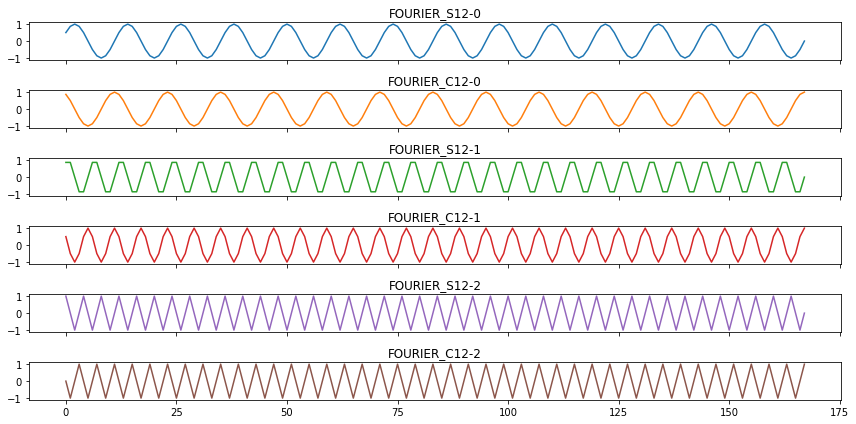

In [20]:


fourier_features = len(fourier.columns)
f, axs = plt.subplots(fourier_features, 1, figsize=(12, 1*fourier_features), sharex=True, sharey=True)

for ix in np.arange(fourier_features):
    ax = axs[ix]
    fourier.iloc[:, ix].plot(ax=ax, color=f"C{ix}")
    ax.set_title(fourier.iloc[:, ix].name)

plt.tight_layout()

### ARIMA Model

In [21]:
from pmdarima import arima

ar = arima.AutoARIMA(
    stepwise=True, trace=1, error_action="ignore",
    seasonal=False,  # because we use VCI
    suppress_warnings=True
)

In [22]:
ar.fit(tgt.dropna())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1520.629, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1834.389, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1535.529, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1684.595, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1535.155, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1537.583, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1522.629, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1537.196, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1528.322, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1538.766, Time=0.04 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1517.425, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1515.430, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1

AutoARIMA(D=None, alpha=0.05, d=None, error_action='ignore',
          information_criterion='aic', m=1, max_D=1, max_P=2, max_Q=2, max_d=2,
          max_order=5, max_p=5, max_q=5, maxiter=50, method='lbfgs', n_fits=10,
          n_jobs=1, offset_test_args=None, out_of_sample_size=0, random=False,
          random_state=None, scoring='mse', scoring_args=None, seasonal=False,
          seasonal_test='ocsb', seasonal_test_args=None, start_P=1, start_Q=1,
          start_p=2, start_params=None, ...)

In [23]:
?ar.predict

Signature:
ar.predict(
    self,
    n_periods=10,
    X=None,
    return_conf_int=False,
    alpha=0.05,
    **kwargs,
)
Docstring: <no docstring>
File:      ~/miniconda3/envs/ml/lib/python3.8/site-packages/pmdarima/arima/auto.py
Type:      function


In [24]:
y_hat = ar.predict()

In [25]:
y_hat

array([81.18042756, 69.77164396, 60.34443366, 54.51398846, 51.31284291,
       49.6670273 , 48.85560297, 48.46708922, 48.28506185, 48.20120231])